### Parameter recovery code - in orientation to: 
https://github.com/hcp4715/dockerHDDM/blob/master/dockerHDDMTutorial/Parameter_recovery.ipynb

### this is code for the parameter recovery of OV-modulated model

In [26]:
%matplotlib inline

# scitnific computing and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr
import statsmodels.api as sm

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


- model for ES and EE: 
v_reg = {'model': 'v ~ 1 + AttentionW + InattentionW:C(OVcate)', 'link_func': lambda x: x}
reg_descr = [v_reg]
depends_on = {'t': 'OVcate'}
- at the group level: a, AttentionW, intercept

- model for ESEE:

v_reg = {'model': 'v ~ 1 + AttentionW + InattentionW:C(phase)', 'link_func': lambda x: x}
reg_descr = [v_reg]
depends_on = {'t': 'phase'}
- at the group level: a, AttentionW, intercept

### reg_plot_with_corr does this: It plots a scatterplot with a regression line, and annotates the plot with:

- Pearson correlation coefficient (r)

- p-value

- Regression intercept (β₀)

- Regression slope (β₁)

In [27]:
# paths

model_dir = "/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV"   # this is obviously variable depending on the model you use
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
# here also improatant, set which model to lead (concatenate the chains you ran)
chain0 = az.from_netcdf("/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV/OV_replication_ES_7_0.nc")
chain1 = az.from_netcdf("/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV/OV_replication_ES_7_1.nc")
chain2 = az.from_netcdf("/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV/OV_replication_ES_7_2.nc")
chain3 = az.from_netcdf("/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV/OV_replication_ES_7_3.nc")
chain4 = az.from_netcdf("/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV/OV_replication_ES_7_4.nc")


In [31]:
ee5_infdata = az.concat([ chain2, chain4, chain3, chain0], dim="chain")


In [32]:
# some functions for some plots
def regplot_with_corr(
    data=None,
    x="x",
    y="y",
    cor_anonot=True,
    reg_anonot=True,
    annot_kws={
        "fontsize": 8,
        "xy": (0.95, 0.05),
        "ha": 'right',
        "va": 'bottom'
    },
    scatter_kws={
        's': 40,
        "alpha": 0.4
    },
    ax=None,
    **kwargs
):
    """

    Example:
    --------
    >>> Example usage
    >>> import pandas as pd
    >>> data = pd.DataFrame({'x': [1, 2, 3, 4, 5], 'y': [2, 3, 5, 7, 11]})
    >>> regplot_with_corr(data)
    >>> plt.show()
    """
    if ax is None:
        ax = plt.gca()
    if data is not None:
        data_x = data[x]
        data_y = data[y]
    else: 
        data_x = x
        data_y = y

    # Plot regression line and scatter plot
    sns.regplot(
        x=data_x,
        y=data_y,
        ci=None if len(np.unique(data_y)) == 1 else 95,
        scatter_kws=scatter_kws,
        ax=ax
    )

    annot_text = ""
    if cor_anonot:
        # Calculate Pearson correlation
        correlation, p_value = pearsonr(data_x, data_y)
        # if np.isnan(correlation):
        #     correlation = 0
        # if np.isnan(p_value):
        #     p_value = 1
        p_str = "p < 0.001" if p_value < 0.001 else f"p = {p_value:.3f}"
        annot_text += f"$r={correlation:.2f}$\n${p_str}$"

    if reg_anonot:
        # Calculate regression coefficients
        X = sm.add_constant(data_x)  # Adds a constant term to the predictor
        model = sm.OLS(data_y, X).fit()
        intercept, slope = model.params
        annot_text += f"\n$\\beta_0={intercept:.2f}$\n$\\beta_1={slope:.2f}$"

    # Annotate the plot with correlation, p-value, intercept, and slope
    if annot_text != "":
        ax.annotate(
            annot_text,
            **annot_kws,
            xycoords='axes fraction',
            bbox=dict(
                boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'
            )
        )
    
    return ax


def az_summary(infdata=None, half_a=False, param_names_order=None, **kwargs):

    param_df = az.summary(infdata, kind="stats",
                            **kwargs).reset_index(names="param_name")
    # col_values = ['mean', 'sd', "hdi_3%", "hdi_97%"]
    col_values = list(param_df.columns[1:5])

    pattern = r'(.*)_subj\.(\d+)'

    param_df[['param',
                'subj_idx']] = param_df['param_name'].str.extract(pattern)
    # param_df['param'] = param_df['param'].apply(lambda x: f'${x}$')
    param_df = param_df.dropna(subset=['subj_idx'])
    param_df['subj_idx'] = param_df['subj_idx'].astype(int)

    if half_a:
        param_df.loc[param_df['param'] == 'a',
                        col_values] = param_df.loc[param_df['param'] == 'a',
                                                col_values] / 2

    param_df = param_df.pivot(
        index='subj_idx', columns='param', values=col_values
    )

    if param_names_order is not None:
        new_index = pd.MultiIndex.from_tuples(
            [
                (level_0, param) for level_0 in col_values
                for param in param_names_order
            ],
            names=[None, 'param']
        )
        param_df = param_df.reindex(columns=new_index)

    param_df.reset_index(inplace=True)
    param_df.columns.names = [None, None]

    return param_df

In [33]:
summary_df = az_summary(ee5_infdata)['mean']
print(summary_df.columns.tolist())


['a', 'v_AttentionW:C(OVcate)[high]', 'v_AttentionW:C(OVcate)[low]', 'v_AttentionW:C(OVcate)[medium]', 'v_InattentionW', 'v_Intercept']


In [34]:
ee5_infdata


Inference data with groups:
	> posterior
	> posterior_predictive
	> observed_data

In [35]:

# read in model
data_EE_5 = ee5_infdata.observed_data.to_dataframe().reset_index(drop=True)

df_ind_summary = data_EE_5.groupby(['subj_idx','OVcate'])['rt'].describe().reset_index()
df_ind_summary = df_ind_summary.set_index('subj_idx').join(
     az_summary(ee5_infdata)['mean'].reset_index(names=['subj_idx']).set_index('subj_idx')
     ).reset_index()
df_ind_summary.head()

,subj_idx,OVcate,count,mean,std,min,25%,50%,75%,max,a,v_AttentionW:C(OVcate)[high],v_AttentionW:C(OVcate)[low],v_AttentionW:C(OVcate)[medium],v_InattentionW,v_Intercept
0,1,high,95.0,0.724407,1.252764,-2.905454,0.575236,0.849663,1.355276,3.960299,2.300,0.026,0.015,0.019,0.017,0.573
1,1,low,125.0,0.898440,1.584949,-4.820869,0.646403,1.060979,1.760213,4.493053,2.300,0.026,0.015,0.019,0.017,0.573
2,1,medium,140.0,0.770984,0.927857,-4.424357,0.689111,0.862326,1.182524,2.663171,2.300,0.026,0.015,0.019,0.017,0.573
3,3,high,94.0,1.190783,1.102676,-1.576013,0.823483,1.031283,1.685869,5.341147,2.021,0.024,0.002,0.014,0.024,0.342
4,3,low,124.0,1.159432,1.444851,-4.119161,0.798093,1.123005,1.517672,8.434638,2.021,0.024,0.002,0.014,0.024,0.342


In [36]:
print(ee5_infdata.groups())


['posterior', 'posterior_predictive', 'observed_data']


In [37]:
def az_summary_group(infdata, **kwargs):
    # full summary as a DataFrame
    summary_df = az.summary(infdata, kind="stats", **kwargs).reset_index()
    # Check the actual column name for parameters (might be 'index' instead of 'param_name')
    param_col = 'index' if 'index' in summary_df.columns else 'param_name'
    # Set the index to the parameter names and select the mean estimates
    return summary_df.set_index(param_col)["mean"]

In [38]:
# check what's in the infdata
group_params = az_summary_group(ee5_infdata)
print(group_params.index.tolist())


['a', 'a_std', 'a_subj.1', 'a_subj.3', 'a_subj.4', 'a_subj.5', 'a_subj.7', 'a_subj.8', 'a_subj.10', 'a_subj.11', 'a_subj.12', 'a_subj.13', 'a_subj.15', 'a_subj.16', 'a_subj.17', 'a_subj.19', 'a_subj.21', 'a_subj.22', 'a_subj.23', 'a_subj.24', 'a_subj.25', 'a_subj.27', 't(high)', 't(low)', 't(medium)', 't_std', 't_subj(high).1', 't_subj(high).3', 't_subj(high).4', 't_subj(high).5', 't_subj(high).7', 't_subj(high).8', 't_subj(high).10', 't_subj(high).11', 't_subj(high).12', 't_subj(high).13', 't_subj(high).15', 't_subj(high).16', 't_subj(high).17', 't_subj(high).19', 't_subj(high).21', 't_subj(high).22', 't_subj(high).23', 't_subj(high).24', 't_subj(high).25', 't_subj(high).27', 't_subj(low).1', 't_subj(low).3', 't_subj(low).4', 't_subj(low).5', 't_subj(low).7', 't_subj(low).8', 't_subj(low).10', 't_subj(low).11', 't_subj(low).12', 't_subj(low).13', 't_subj(low).15', 't_subj(low).16', 't_subj(low).17', 't_subj(low).19', 't_subj(low).21', 't_subj(low).22', 't_subj(low).23', 't_subj(low).2

In [39]:
# First get all group and subject-level parameters properly
group_params = az.summary(ee5_infdata, var_names=['~subj', '~std'], filter_vars='regex')
subject_params = az_summary(ee5_infdata)['mean'] 

# mapping of subject-specific t parameters
t_params = {}
for param in group_params.index:
    if param.startswith('t_subj'):
        # extract components like: 't_subj(high).2' -> (2, 'high', value)
        parts = param.split(')')
        ov_level = parts[0].split('(')[1]
        subj_id = int(parts[1].split('.')[1])
        if subj_id not in t_params:
            t_params[subj_id] = {}
        t_params[subj_id][ov_level] = group_params.loc[param, 'mean']
        
sim_data = pd.DataFrame()
# loop over each subject and condition from the original data
for (subj, ov), trial_group in data_EE_5.groupby(['subj_idx','OVcate']):
    # Get the subject-by-condition summary values from df_ind_summary
    j = df_ind_summary[(df_ind_summary['subj_idx'] == subj) & (df_ind_summary['OVcate'] == ov)].iloc[0]
    
    # estimated parameters (computed from original model)
    a_val = j["a"]
    v_int = j["v_Intercept"]
    v_att = j["v_InattentionW"]
    v_inatt = j[f"v_AttentionW:C(OVcate)[{ov}]"]

    # Get non-decision time t for this subject and condition from your t_params mapping
    try:
        t_val = t_params[int(subj)][ov.lower()]
    except KeyError:
        t_val = group_params.loc[f't({ov.lower()})', 'mean']
    
    # for each trial in this subject and condition, use actual AttentionW and InattentionW
    for idx, trial in trial_group.iterrows():
        att_val = trial["AttentionW"]      
        inatt_val = trial["InattentionW"]   
        # Get the drift rate for this trial:
        v_trial = v_int + v_att * att_val + v_inatt * inatt_val   # not sure if this is best practice (add weight of attention and inattention to the drift intercept)
        
        # we simulate one trial per original trial (size=1) – we could also simulate multiple trials per original trial
        sim_trial, _ = hddm.generate.gen_rand_data(
            {"v": v_trial, "a": a_val, "t": t_val},
            size=1,
            subjs=1,
        )
        sim_trial["subj_idx"] = subj
        sim_trial["OVcate"] = ov
        # keep the trial-level predictors for later checking
        sim_trial["AttentionW"] = att_val
        sim_trial["InattentionW"] = inatt_val

        sim_data = pd.concat([sim_data, sim_trial], ignore_index=True)

# drop any extra columns if needed
if 'condition' in sim_data.columns:
    sim_data.drop('condition', axis=1, inplace=True)

# check simulated data
print(sim_data.head(10))
print("\nUnique subjects in simulation:", sim_data['subj_idx'].nunique())
print("OVcate counts in simulation:\n", sim_data['OVcate'].value_counts())

print(sim_data.to_string())


      rt  response  subj_idx OVcate  AttentionW  InattentionW
0  0.934       1.0         1   high       5.637        44.363
1  1.442       1.0         1   high      19.130        -9.130
2  0.736       1.0         1   high      28.587       -18.587
3  1.721       1.0         1   high       0.000         0.000
4  2.775       0.0         1   high      65.873       -45.873
5  0.733       1.0         1   high      31.777       -11.777
6  0.765       1.0         1   high       0.000         0.000
7  2.070       1.0         1   high      10.408         9.592
8  1.150       1.0         1   high       3.950        46.050
9  0.621       1.0         1   high      35.547       -25.547

Unique subjects in simulation: 20
OVcate counts in simulation:
 OVcate
medium    2542
low       2292
high      1714
Name: count, dtype: int64
         rt  response  subj_idx  OVcate  AttentionW  InattentionW
0     0.934       1.0         1    high       5.637        44.363
1     1.442       1.0         1    high    

In [ ]:
# First get all group and subject-level parameters properly
group_params = az.summary(ee5_infdata, var_names=['~subj', '~std'], filter_vars='regex')
subject_params = az_summary(ee5_infdata)['mean'] 

# mapping of subject-specific t parameters
t_params = {}
for param in group_params.index:
    if param.startswith('t_subj'):
        # extract components like: 't_subj(high).2' -> (2, 'high', value)
        parts = param.split(')')
        ov_level = parts[0].split('(')[1]
        subj_id = int(parts[1].split('.')[1])
        if subj_id not in t_params:
            t_params[subj_id] = {}
        t_params[subj_id][ov_level] = group_params.loc[param, 'mean']
        
sim_data = pd.DataFrame()
# loop over each subject and condition from the original data
for (subj, ov), trial_group in data_EE_5.groupby(['subj_idx','OVcate']):
    # Get the subject-by-condition summary values from df_ind_summary
    j = df_ind_summary[(df_ind_summary['subj_idx'] == subj) & (df_ind_summary['OVcate'] == ov)].iloc[0]
    
    # estimated parameters (computed from original model)
    a_val = j["a"]
    v_int = j["v_Intercept"]
    v_att = j["v_AttentionW"]
    v_inatt = j[f"v_InattentionW:C(OVcate)[{ov}]"]

    # Get non-decision time t for this subject and condition from your t_params mapping
    try:
        t_val = t_params[int(subj)][ov.lower()]
    except KeyError:
        t_val = group_params.loc[f't({ov.lower()})', 'mean']
    
    # for each trial in this subject and condition, use actual AttentionW and InattentionW
    for idx, trial in trial_group.iterrows():
        att_val = trial["AttentionW"]      
        inatt_val = trial["InattentionW"]   
        # Get the drift rate for this trial:
        v_trial = v_int + v_att * att_val + v_inatt * inatt_val   # not sure if this is best practice (add weight of attention and inattention to the drift intercept)
        
        # we simulate one trial per original trial (size=1) – we could also simulate multiple trials per original trial
        sim_trial, _ = hddm.generate.gen_rand_data(
            {"v": v_trial, "a": a_val, "t": t_val},
            size=1,
            subjs=1,
        )
        sim_trial["subj_idx"] = subj
        sim_trial["OVcate"] = ov
        # keep the trial-level predictors for later checking
        sim_trial["AttentionW"] = att_val
        sim_trial["InattentionW"] = inatt_val

        sim_data = pd.concat([sim_data, sim_trial], ignore_index=True)

# drop any extra columns if needed
if 'condition' in sim_data.columns:
    sim_data.drop('condition', axis=1, inplace=True)

# check simulated data
print(sim_data.head(10))
print("\nUnique subjects in simulation:", sim_data['subj_idx'].nunique())
print("OVcate counts in simulation:\n", sim_data['OVcate'].value_counts())

print(sim_data.to_string())


In [40]:
sim_data = sim_data[sim_data['subj_idx'] < 20]


In [41]:
print(sim_data[['subj_idx', 'OVcate', 'rt', 'response']].head())
print("\nUnique subjects:", sim_data['subj_idx'].nunique())
print("OVcate counts:\n", sim_data['OVcate'].value_counts())

   subj_idx OVcate     rt  response
0         1   high  0.934       1.0
1         1   high  1.442       1.0
2         1   high  0.736       1.0
3         1   high  1.721       1.0
4         1   high  2.775       0.0

Unique subjects: 14
OVcate counts:
 OVcate
medium    1828
low       1649
high      1239
Name: count, dtype: int64


In [42]:

#if 'AttentionW' not in sim_data.columns:
#    sim_data['AttentionW'] = 1.0  # Fixed value as used in simulation
#if 'InattentionW' not in sim_data.columns:
#    sim_data['InattentionW'] = 1.0  # Fixed value as used in simulation

# helper function to wrap the sampling procedure
def run_sampling(model, model_db_name, progress_bar=True):
    model.find_starting_values()
    result = model.sample(
        2000,                 # nr of samples (
        burn=100,            # Burn-in samples
        dbname=model_db_name,# path for saving the chain
        db='pickle',         # Save chain using pickle
        return_infdata=True, # Return an InferenceData object for diagnostics/plots
        loglike=True,        # allow for loglikelihood computation
        ppc=True             # to get the ppc
    )
    if isinstance(result, tuple):
        model_out = result[0]
        infdata = result[1]
        return model_out, infdata
    else:
        return model, result

# model specification (best fitting OV-modulated Inattention and t model)
v_reg = {'model': 'v ~ 1 + AttentionW:C(OVcate) + InattentionW', 'link_func': lambda x: x}
reg_descr = [v_reg]
depends_on = {'t': 'OVcate'}

# HDDMRegressor using simulated data
m_recovery = hddm.HDDMRegressor(
    sim_data,              
    reg_descr,             
    depends_on=depends_on, 
    include=['a', 't', 'v'], 
    p_outlier=0.05,
    group_only_regressors=False,
    keep_regressor_trace=True
)

# full path for saving
model_db_name = os.path.join(model_dir, "mES_7_recovery")

m_recovery, m_recovery_infdata = run_sampling(m_recovery, model_db_name, progress_bar=False)

# InferenceData as .nc
az.to_netcdf(m_recovery_infdata, os.path.join(model_dir, "mES_7_recovery.nc"))



No model attribute --> setting up standard HDDM
Set model to ddm


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2001 of 2000 complete in 1145.6 sechddm sampling elpased time:  1146.885 s
Start converting to InferenceData...
Start to calculate pointwise log likelihood...
The time of calculation of loglikelihood took 111.295 seconds
Start generating posterior prediction...
fail to convert posterior predictive check (self.ppc) to xarray: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGSEGV(-11)}


'/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV/mES_7_recovery.nc'

In [46]:
# recovered model InferenceData from .nc file
model_dir = "/home/jovyan/OfficialTutorials/For_Linux/models_dir_OV"
recovered_nc = os.path.join(model_dir, "mES_7_recovery.nc")
m_recovery_infdata = az.from_netcdf(recovered_nc)


In [47]:
fig_dir = "/home/jovyan/OfficialTutorials/For_Linux/figures_dir_OV/OV_replication_ES_7/diagnostics"

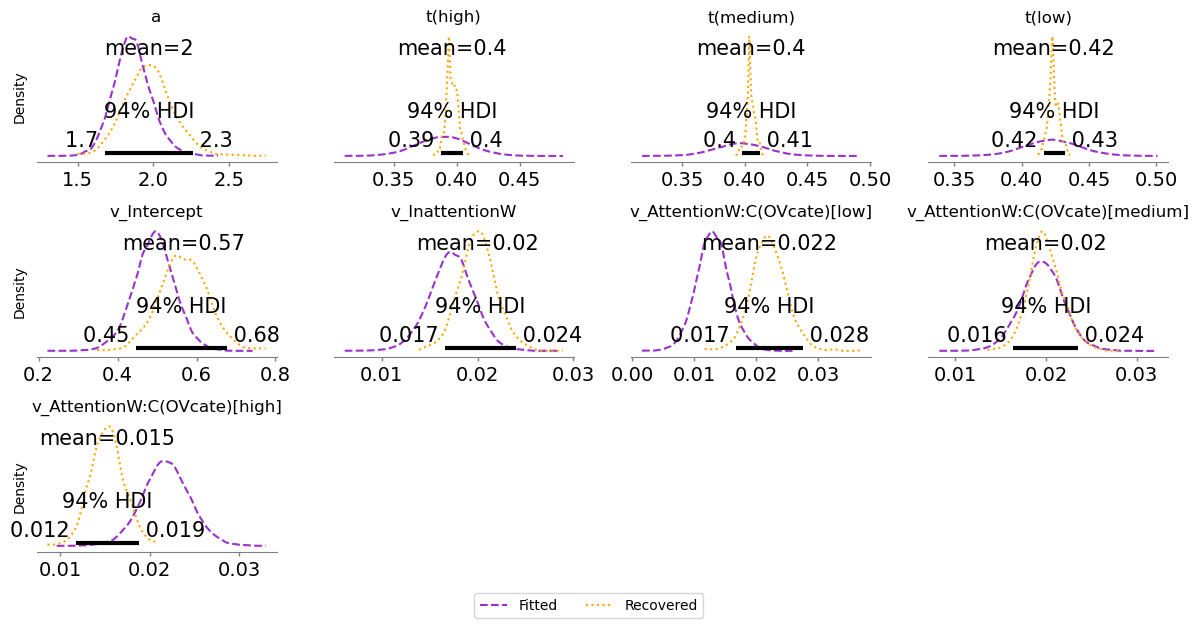

In [48]:
param_list = [
    'a',
    't(high)', 't(medium)', 't(low)',
    'v_Intercept',
    'v_InattentionW',
    'v_AttentionW:C(OVcate)[low]',
    'v_AttentionW:C(OVcate)[medium]',
    'v_AttentionW:C(OVcate)[high]'
]

n_params = len(param_list)
n_cols = 4
figsize = (12, 6)
n_rows = (n_params + n_cols - 1) // n_cols

f, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
ax = ax.flatten()

# plot posterior distributions from original (fitted) model and the recovered model
# ee5_infdata is the original model's InferenceData
# m2_recovery_infdata is the one from the recovered model
for i, param in enumerate(param_list):
    az.plot_posterior(                         # fitted
        ee5_infdata.posterior[param],
        ax=ax[i],
        color="darkorchid",                 #darkorchid
        linestyle="dashed",
        label="Fitted",
        hdi_prob='hide',
        point_estimate=None
    )
    az.plot_posterior(                         # recovered
        m_recovery_infdata.posterior[param],
        ax=ax[i],
        color="orange",
        linestyle="dotted",
        label="Recovered"
    )
    ax[i].set_ylabel('Density' if i % n_cols == 0 else '')
    ax[i].set_title(param)
    if i == 0:
        handles, labels = ax[0].get_legend_handles_labels()
    if ax[i].get_legend():
        ax[i].legend_.remove()

for j in range(i + 1, len(ax)):
    f.delaxes(ax[j])

f.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.tight_layout()

plot_path = os.path.join(fig_dir, "Posterior_dens_fitted_recov.png")
plt.savefig(plot_path, dpi=300, bbox_inches='tight')

plt.show()


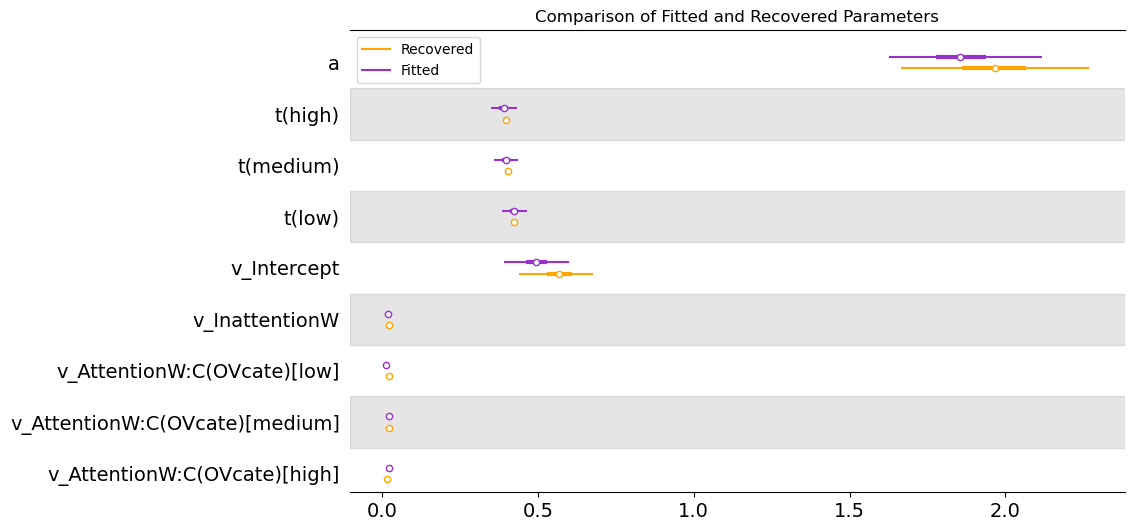

In [49]:
# Forest Plot for Group-level Parameters
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_forest(
    [ee5_infdata, m_recovery_infdata],
    model_names=["Fitted", "Recovered"],
    var_names=param_list,
    combined=True,
    ridgeplot_alpha=0.5,
    colors=["darkorchid", "orange"],               #darkorchid
    hdi_prob=0.95,
    ax=ax
)
ax.set_title("Comparison of Fitted and Recovered Parameters")
# IMPORTANT - make sure this fits the model and path
plot_path2 = os.path.join(fig_dir, "Compa_fitted_recov.png")

plt.savefig(plot_path2, dpi=300, bbox_inches='tight')

plt.show()



In [50]:
# figure size (smaller width, less height)
fig, ax = plt.subplots(figsize=(7, 4.5))  # try something like 7x4.5 inches

az.plot_forest(
    [ee5_infdata, m_recovery_infdata],
    model_names=["Fitted", "Recovered"],
    var_names=param_list,
    combined=True,
    ridgeplot_alpha=0.5,
    colors=["darkorchid", "orange"],                    #darkorchid
    hdi_prob=0.95,
    ax=ax
)

ax.set_title("Comparison of Fitted and Recovered Parameters", fontsize=11)
ax.tick_params(axis='x', labelsize=10)  
ax.tick_params(axis='y', labelsize=10) 

plt.savefig(
    "/home/jovyan/OfficialTutorials/For_Linux/figures_dir_OV/OV_replication_ES_7/diagnostics/fitted_recov_hdi.png",
    dpi=600,               # high resolution
    bbox_inches='tight',   # removes extra white space
    transparent=False
)
plt.close()  


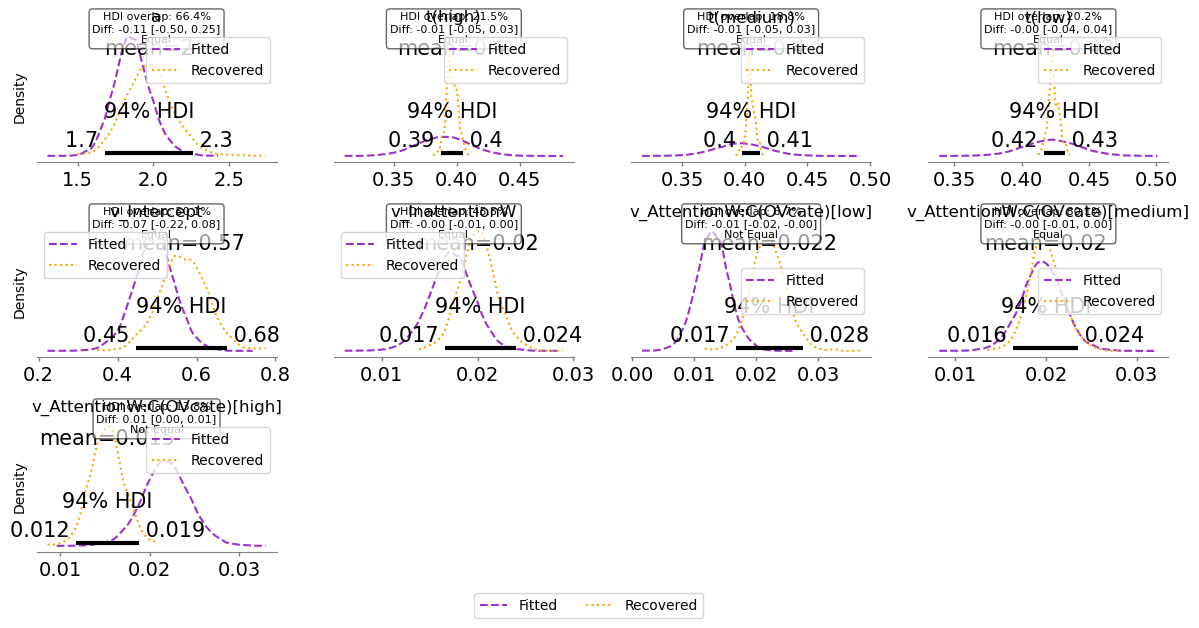

Summary exported to /home/jovyan/OfficialTutorials/For_Linux/figures_dir_OV/OV_replication_ES_7/diagnostics/parameter_recovery_summary_ES_7.csv
                        Parameter  HDI_Overlap                Diff_Mean   
0                               a     0.664193     -0.10882247425512685  \
1                         t(high)     0.214899    -0.007107321046944102   
2                       t(medium)     0.188092    -0.007380950636312138   
3                          t(low)     0.202118   -0.0017987832237842006   
4                     v_Intercept     0.500562       -0.072464828184282   
5                  v_InattentionW     0.454851   -0.0028884440697613733   
6     v_AttentionW:C(OVcate)[low]     0.067293    -0.009063553548780747   
7  v_AttentionW:C(OVcate)[medium]     0.800685  -0.00047381545799767585   
8    v_AttentionW:C(OVcate)[high]     0.137821     0.006390938810492849   

   Diff_Lower  Diff_Upper  Equal  
0   -0.499418    0.249485   True  
1   -0.052698    0.029881   True  


In [51]:
# function to compute HDI overlap
def hdi_overlap(idata1, idata2, var_name, hdi_prob=0.94):
    """
    Compute the percent overlap of the HDIs between two posterior distributions
    """
    hdi1 = az.hdi(idata1.posterior[var_name], hdi_prob=hdi_prob).to_array().values
    hdi2 = az.hdi(idata2.posterior[var_name], hdi_prob=hdi_prob).to_array().values
    lower1, upper1 = hdi1.min(), hdi1.max()
    lower2, upper2 = hdi2.min(), hdi2.max()
    overlap = max(0, min(upper1, upper2) - max(lower1, lower2))
    total_range = max(upper1, upper2) - min(lower1, lower2)
    return overlap / total_range if total_range > 0 else 0

# function to compute difference HDI and check for overlap with 0
def difference_hdi(idata1, idata2, var_name, hdi_prob=0.94):
    """
    Compute the posterior difference (fitted minus recovered) for a parameter,
    then calculate the mean difference and its HDI.
    
    Returns:
        diff_mean: Mean difference
        diff_lower: Lower bound of the HDI
        diff_upper: Upper bound of the HDI
        equal: Boolean; True if the HDI includes 0 (interpreted as "Equal")
    """
    diff = idata1.posterior[var_name] - idata2.posterior[var_name]
    # Get HDI of the difference
    hdi_diff = az.hdi(diff, hdi_prob=hdi_prob).to_array().values
    lower, upper = hdi_diff.min(), hdi_diff.max()
    diff_mean = diff.mean().values
    # If 0 is within the interval, flag the difference as "Equal"
    equal = (lower <= 0) and (upper >= 0)
    return diff_mean, lower, upper, equal

# list of parameters 
param_list = [
    'a',
    't(high)', 't(medium)', 't(low)',
    'v_Intercept',
    'v_InattentionW',
    'v_AttentionW:C(OVcate)[low]',
    'v_AttentionW:C(OVcate)[medium]',
    'v_AttentionW:C(OVcate)[high]'
]

# plotting and summary collection
n_params = len(param_list)
n_cols = 4
figsize = (12, 6)
n_rows = (n_params + n_cols - 1) // n_cols

f, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
ax = ax.flatten()

summary_data = []


for i, param in enumerate(param_list):
    try:
        # fitted posterior (specific colour for the phase)  darkorchid = ES, deepksyblue = EE, grey = ESEE
        az.plot_posterior(
            ee5_infdata.posterior[param],
            ax=ax[i],
            color="darkorchid",
            linestyle="dashed",
            label="Fitted",
            hdi_prob='hide',
            point_estimate=None
        )
        az.plot_posterior(
            m_recovery_infdata.posterior[param],
            ax=ax[i],
            color="orange",                                     # recovred always orange
            linestyle="dotted",
            label="Recovered"
        )
        ax[i].set_ylabel('Density' if i % n_cols == 0 else '')
        ax[i].set_title(param)
        
        # get HDI overlap between the posteriors
        hdi_ol = hdi_overlap(ee5_infdata, m_recovery_infdata, param)
        # get the difference (fitted - recovered) and its HDI
        diff_mean, diff_lower, diff_upper, equal = difference_hdi(ee5_infdata, m_recovery_infdata, param)
        equality_str = "Equal" if equal else "Not Equal"
        
        annotation = (f"HDI overlap: {hdi_ol:.1%}\n"
                      f"Diff: {diff_mean:.2f} [{diff_lower:.2f}, {diff_upper:.2f}]\n"
                      f"{equality_str}")
        ax[i].annotate(annotation, xy=(0.5, 0.9), xycoords='axes fraction',
                       ha='center', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))
        
        summary_data.append({
            'Parameter': param,
            'HDI_Overlap': hdi_ol,
            'Diff_Mean': diff_mean,
            'Diff_Lower': diff_lower,
            'Diff_Upper': diff_upper,
            'Equal': equal
        })
    except Exception as e:
        print(f"Could not process param '{param}': {e}")
        ax[i].axis('off')

for j in range(i + 1, len(ax)):
    f.delaxes(ax[j])

# legend
handles, labels = ax[0].get_legend_handles_labels()
f.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=2)
plt.tight_layout()
plt.show()

# CSV
summary_df = pd.DataFrame(summary_data)
csv_filename = "/home/jovyan/OfficialTutorials/For_Linux/figures_dir_OV/OV_replication_ES_7/diagnostics/parameter_recovery_summary_ES_7.csv"
summary_df.to_csv(csv_filename, index=False)
print(f"Summary exported to {csv_filename}")
print(summary_df)


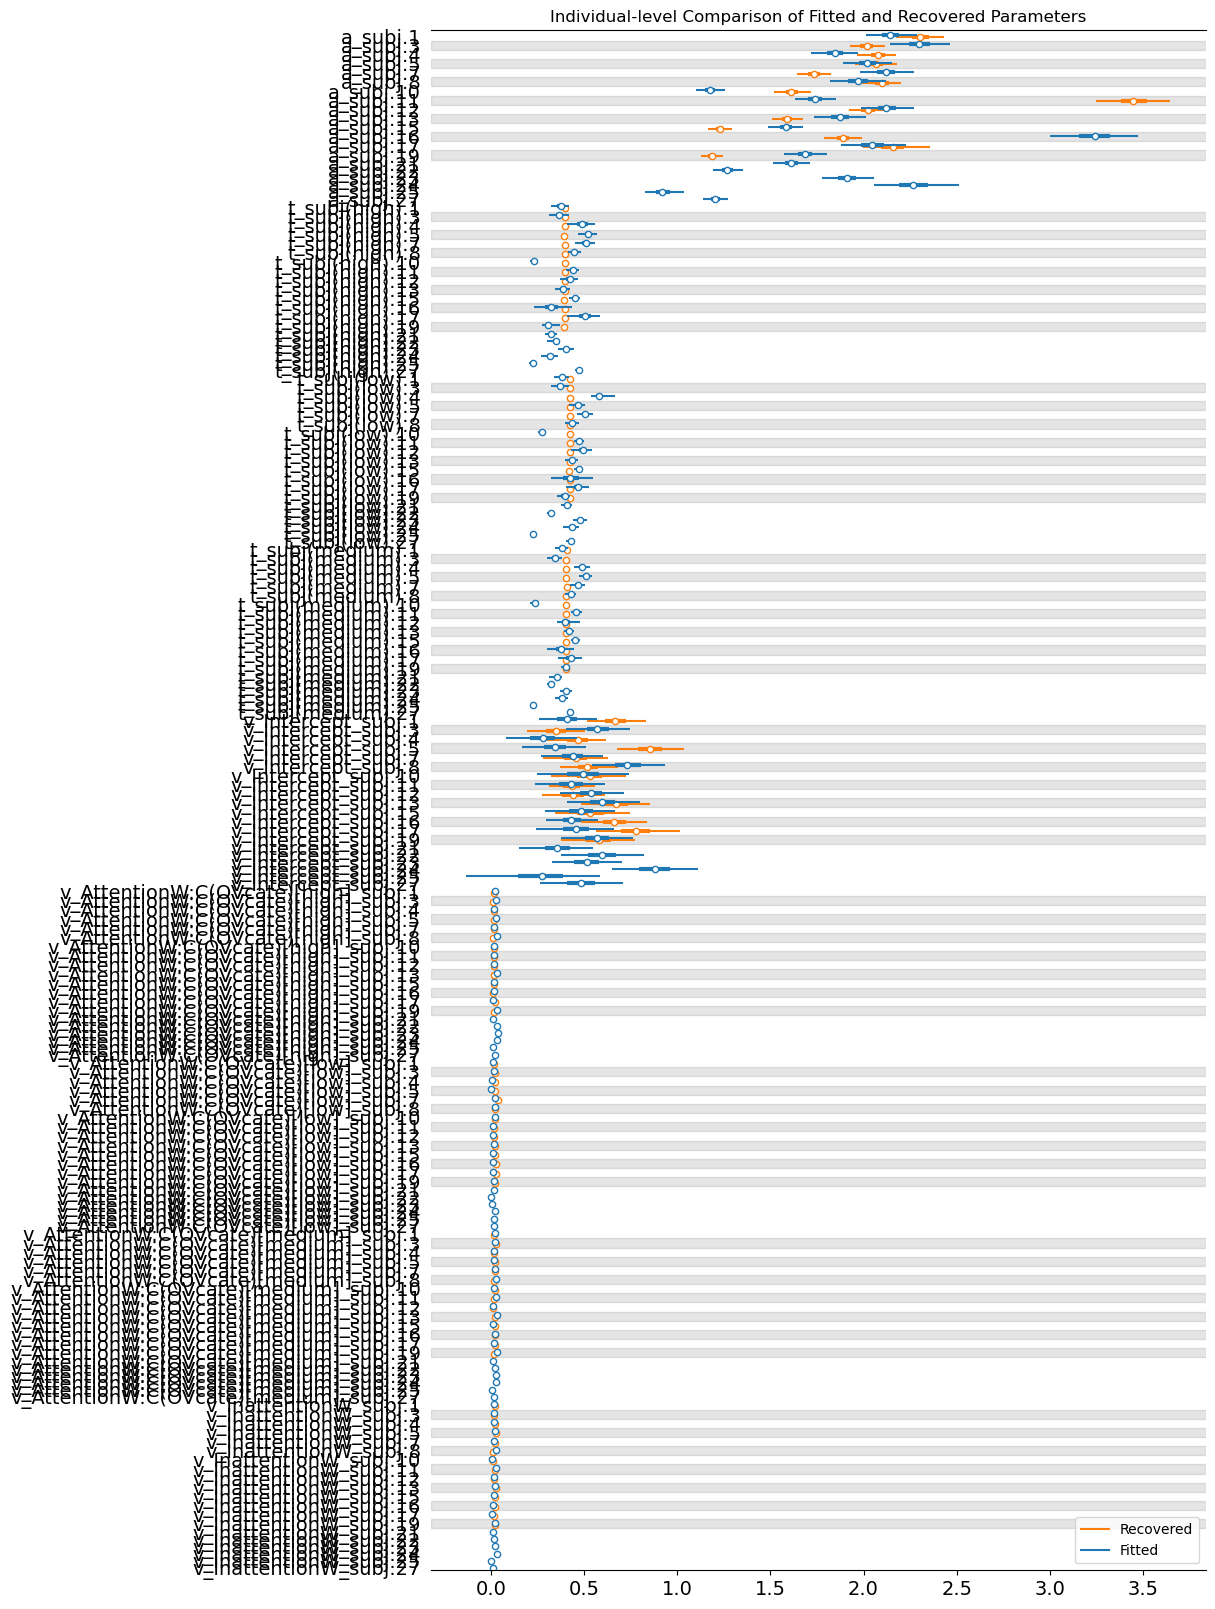

In [52]:
# Individual-level Comparison, forest plot
ind_param_list = [param for param in ee5_infdata.posterior.data_vars if 'subj' in param and 'std' not in param]
fig, ax = plt.subplots(figsize=(10, 20))
az.plot_forest(
    [ee5_infdata, m_recovery_infdata],
    model_names=["Fitted", "Recovered"],
    var_names=ind_param_list,
    combined=True,
    ridgeplot_alpha=0.5,
    hdi_prob=0.95,
    ax=ax
)
ax.set_title("Individual-level Comparison of Fitted and Recovered Parameters")
plt.show()

In [53]:
ee5_infdata

Inference data with groups:
	> posterior
	> posterior_predictive
	> observed_data

Columns in param_fitted:
 Index(['subj_idx', 'a', 't(high)', 't(low)', 't(medium)',
       'v_AttentionW:C(OVcate)[high]', 'v_AttentionW:C(OVcate)[low]',
       'v_AttentionW:C(OVcate)[medium]', 'v_InattentionW', 'v_Intercept'],
      dtype='object', name='param')
Columns in param_recovery:
 Index(['subj_idx', 'a', 't(high)', 't(low)', 't(medium)',
       'v_AttentionW:C(OVcate)[high]', 'v_AttentionW:C(OVcate)[low]',
       'v_AttentionW:C(OVcate)[medium]', 'v_InattentionW', 'v_Intercept'],
      dtype='object', name='param')

Adjusted 'a' in recovery model to match fitted scale.

After filtering and aligning subjects:
Fitted shape: (14, 9)
Recovered shape: (14, 9)
Param 't' not in param_fitted columns!
Param 'a(low)' not in param_fitted columns!
Param 'a(medium)' not in param_fitted columns!
Param 'a(high)' not in param_fitted columns!
Param 'v_AttentionW' not in param_fitted columns!
Param 'v_InattentionW:C(OVcate)[low]' not in param_fitted columns!
Param 'v_InattentionW:C(OVcate)[me

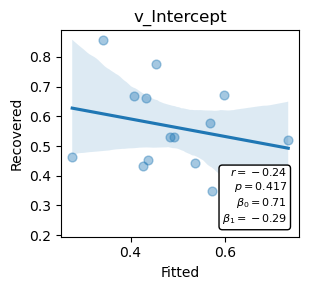

In [ ]:
def regplot_with_corr(
    x, 
    y, 
    ax=None,
    cor_anonot=True,
    reg_anonot=True,
    annot_kws=None,
    scatter_kws=None
):
    """
    Scatter + regression line plot with correlation annotation
    `x` and `y` should be 1D arrays/Series of the same length
    """
    if annot_kws is None:
        annot_kws = {"fontsize": 8, "xy": (0.95, 0.05), "ha": 'right', "va": 'bottom'}
    if scatter_kws is None:
        scatter_kws = {'s': 40, "alpha": 0.4}

    if ax is None:
        ax = plt.gca()

    sns.regplot(
        x=x,
        y=y,
        ci=None if len(np.unique(y)) == 1 else 95,
        scatter_kws=scatter_kws,
        ax=ax
    )

    annot_text = ""

    # Pearson correlation
    if cor_anonot:
        corr, pval = pearsonr(x, y)
        p_str = "p < 0.001" if pval < 0.001 else f"p = {pval:.3f}"
        annot_text += f"$r={corr:.2f}$\n${p_str}$"

    # Regression coefficients
    if reg_anonot:
        X = sm.add_constant(x)  
        model = sm.OLS(y, X).fit()
        intercept, slope = model.params
        annot_text += f"\n$\\beta_0={intercept:.2f}$\n$\\beta_1={slope:.2f}$"

    if annot_text:
        ax.annotate(
            annot_text,
            **annot_kws,
            xycoords='axes fraction',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white')
        )
    return ax


##############################################################################
# function to extract subject‐level parameters and rename them
def extract_subject_level_params(infdata):
    """
    1. Call az.summary(...) to get a DataFrame of all parameters
    2. Keep only rows that have '_subj.' in the param_name, i.e. subject-level
    3. Convert something like 't_subj(low).3' → param='t_subj(low)', subj_idx= 3
    4. Rename 't_subj(low)' -> 't(low)' so you can easily match the final names
    5. Pivot so each subject is a row, each param is a column, the value is 'mean'
    """
    # ArviZ summary
    summary_df = az.summary(infdata, kind="stats").reset_index(names="param_name")

    # Extract param vs. subject ID from param_name
    #    For example:  "t_subj(low).2" -> param="t_subj(low)", subj_idx="2"
    #    pattern: (.*)\.(\d+) to split on the last dot
    #    or  (.*)_subj\.(\d+) 
    pattern = r"(.*)\.(\d+)"
    extracted = summary_df["param_name"].str.extract(pattern)
    summary_df["param"] = extracted[0]  # e.g. "t_subj(low)"
    summary_df["subj_idx"] = extracted[1]
    
    # Keep only subject-level rows (those that have a numeric subj_idx)
    summary_df = summary_df.dropna(subset=["subj_idx"])
    summary_df["subj_idx"] = summary_df["subj_idx"].astype(int)

    # Rename e.g. "t_subj(low)"-> "t(low)" 
    #    "v_InattentionW_subj(high)" -> "v_InattentionW(high)" etc.
    #    We'll do a small replace:  param.replace("t_subj","t")
    #    Then if you also have "v_subj" or "z_subj", do similarly
    def rename_param(p):
        # e.g. "t_subj(low)" => "t(low)"
        p = p.replace("_subj", "")
        return p

    summary_df["param"] = summary_df["param"].apply(rename_param)

    # pivot so rows=subject columns=param values=mean
    pivot_df = summary_df.pivot(index="subj_idx", columns="param", values="mean").copy()
    pivot_df.reset_index(inplace=True)

    return pivot_df


#   ee5_infdata        =>  fitted model
#   m_recovery_infdata =>  recovered model

# extract subject-level parameters
param_fitted = extract_subject_level_params(ee5_infdata)
param_recovery = extract_subject_level_params(m_recovery_infdata)
print("Columns in param_fitted:\n", param_fitted.columns)
print("Columns in param_recovery:\n", param_recovery.columns)

# filter out subjects > 20 (did this because the simulations seemed to have not converged for these or not sure what exactly happened but participants simulated data looked odd)
param_fitted = param_fitted[param_fitted["subj_idx"] <= 20]
param_recovery = param_recovery[param_recovery["subj_idx"] <= 20]

# merge on subj_idx
common_subjs = set(param_fitted["subj_idx"]).intersection(set(param_recovery["subj_idx"]))
param_fitted = param_fitted[param_fitted["subj_idx"].isin(common_subjs)].set_index("subj_idx")
param_recovery = param_recovery[param_recovery["subj_idx"].isin(common_subjs)].set_index("subj_idx")


# a scaling
if "a" in param_fitted.columns and "a" in param_recovery.columns:
    param_recovery["a"] /= 2  
    print("\nAdjusted 'a' in recovery model to match fitted scale.")
print("\nAfter filtering and aligning subjects:")
print("Fitted shape:", param_fitted.shape)
print("Recovered shape:", param_recovery.shape)


param_list = [
    "t",
    "a(low)",
    "a(medium)",
    "a(high)",
    "v_Intercept",
    "v_AttentionW",
    "v_InattentionW:C(OVcate)[low]",
    "v_InattentionW:C(OVcate)[medium]",
    "v_InattentionW:C(OVcate)[high]"
]

# subplot for each param and regplot_with_corr
fig, axes = plt.subplots(ncols=len(param_list), figsize=(3*len(param_list), 3))

for i, p in enumerate(param_list):
    ax = axes[i]
    if p not in param_fitted.columns:
        print(f"Param '{p}' not in param_fitted columns!")
        ax.set_visible(False)
        continue
    if p not in param_recovery.columns:
        print(f"Param '{p}' not in param_recovery columns!")
        ax.set_visible(False)
        continue

    xvals = param_fitted[p].dropna()
    yvals = param_recovery[p].dropna()

    # Keep only the intersection of indices
    valid_idx = xvals.index.intersection(yvals.index)
    xvals = xvals.loc[valid_idx]
    yvals = yvals.loc[valid_idx]

    # if there's no data, skip
    if len(xvals) == 0:
        print(f"No valid data for param '{p}' after intersection!")
        ax.set_visible(False)
        continue
    regplot_with_corr(xvals, yvals, ax=ax)
    ax.set_xlabel("Fitted")
    ax.set_ylabel("Recovered")
    ax.set_title(p)

plt.tight_layout()
plt.show()
